In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for boxplots
import seaborn as sns
#ahmed

In [3]:
key_stats = pd.read_csv('key_stats.csv')
attacking = pd.read_csv('attacking.csv')
defending = pd.read_csv('defending.csv')
attempts = pd.read_csv('attempts.csv')
disciplinary = pd.read_csv('disciplinary.csv')
distributon = pd.read_csv('distributon.csv')
goalkeeping = pd.read_csv('goalkeeping.csv')
goals = pd.read_csv('goals.csv')

In [4]:
# feature engineering

attempts['attempts_accuracy'] = 100 * attempts['on_target'] / attempts['total_attempts']
defending['tackles_accuracy'] = 100* defending['t_won'] / defending['tackles']
defending['balls_recoverd_per_match'] = defending['balls_recoverd'] / defending['match_played']
goals['goals_per_match'] = goals['goals'] / goals['match_played']
goalkeeping['gk_accuracy'] = 100 * goalkeeping['saved'] / (goalkeeping['saved']+goalkeeping['conceded'])
goalkeeping['cleansheets_rate'] = 100 * goalkeeping['cleansheets'] / goalkeeping['match_played']

In [5]:
# merged dataframe

dataframes = [key_stats, attacking, defending, attempts, disciplinary, distributon, goalkeeping, 
              goals]

df = dataframes[0]

for data in dataframes[1:]:
    df = pd.merge(df, data, on='player_name', how='outer', suffixes=('', '_duplicate'))

df = df.loc[:, ~df.columns.str.endswith('_duplicate')]
df = df.loc[:, ~df.columns.str.contains('serial')]
df.head()

,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,corner_taken,offsides,...,gk_accuracy,cleansheets_rate,right_foot,left_foot,headers,others,inside_area,outside_areas,penalties,goals_per_match
0,Aaronson,Salzburg,Midfielder,715.0,8.0,0.0,2.0,103.5,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abubakari,Malmö,Forward,116.0,4.0,0.0,0.0,15.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acuña,Sevilla,Defender,379.0,5.0,0.0,0.0,43.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adams,Leipzig,Midfielder,292.0,5.0,0.0,0.0,38.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adamu,Salzburg,Forward,231.0,8.0,1.0,0.0,32.6,NaN,NaN,...,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.125


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_name               1003 non-null   object 
 1   club                      1002 non-null   object 
 2   position                  1002 non-null   object 
 3   minutes_played            1002 non-null   float64
 4   match_played              1002 non-null   float64
 5   goals                     1002 non-null   float64
 6   assists                   1002 non-null   float64
 7   distance_covered          1002 non-null   object 
 8   corner_taken              328 non-null    float64
 9   offsides                  328 non-null    float64
 10  dribbles                  328 non-null    float64
 11  balls_recoverd            888 non-null    float64
 12  tackles                   888 non-null    float64
 13  t_won                     888 non-null    float64
 14  t_lost  

In [7]:
df.describe()

,minutes_played,match_played,goals,assists,corner_taken,offsides,dribbles,balls_recoverd,tackles,t_won,...,gk_accuracy,cleansheets_rate,right_foot,left_foot,headers,others,inside_area,outside_areas,penalties,goals_per_match
count,1002.000000,1002.000000,1002.000000,1002.000000,328.000000,328.000000,328.000000,888.000000,888.000000,888.000000,...,134.000000,134.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,342.150699,5.194611,0.428144,0.363273,2.158537,0.762195,6.341463,18.012387,5.304054,2.194820,...,83.598326,63.940115,0.924765,0.514107,0.188088,0.012539,1.297806,0.344828,0.112853,0.246109
std,239.140607,2.644628,1.166176,0.821641,5.028286,1.789753,8.747521,15.332058,4.817282,2.444259,...,19.613152,43.092786,1.127409,0.944508,0.491163,0.111449,1.641357,0.532199,0.426840,0.196787
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,42.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
25%,139.750000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,1.000000,0.000000,...,66.666667,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
50%,326.000000,5.000000,0.000000,0.000000,0.000000,0.000000,3.000000,13.000000,4.000000,1.000000,...,100.000000,100.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667
75%,499.750000,7.000000,0.000000,0.000000,1.000000,1.000000,7.000000,24.000000,9.000000,3.000000,...,100.000000,100.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.333333
max,1230.000000,13.000000,15.000000,7.000000,36.000000,10.000000,83.000000,76.000000,35.000000,18.000000,...,100.000000,100.000000,11.000000,8.000000,3.000000,1.000000,13.000000,3.000000,3.000000,1.375000


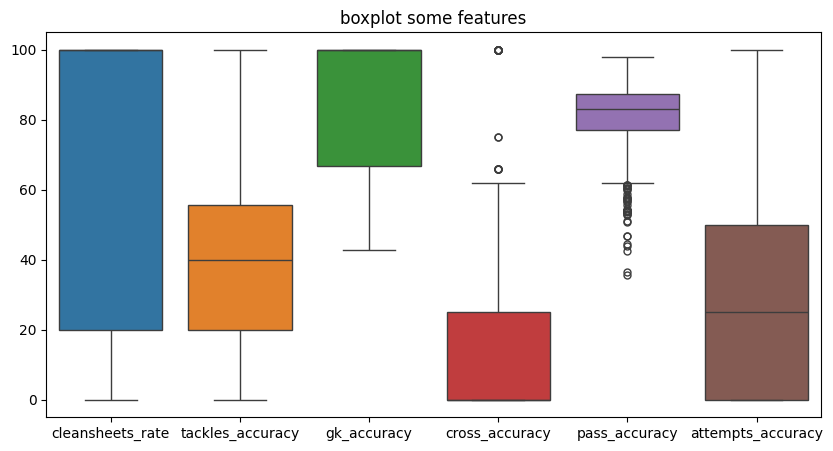

In [8]:
plt.figure(figsize=((10,5)))
plt.title('boxplot some features')
soccer_box=sns.boxplot(data=df[['cleansheets_rate', 'tackles_accuracy','gk_accuracy', 'cross_accuracy', 'pass_accuracy', 'attempts_accuracy']],fliersize=5)   # fliersize is the size used to indicate the outliers
plt.show()

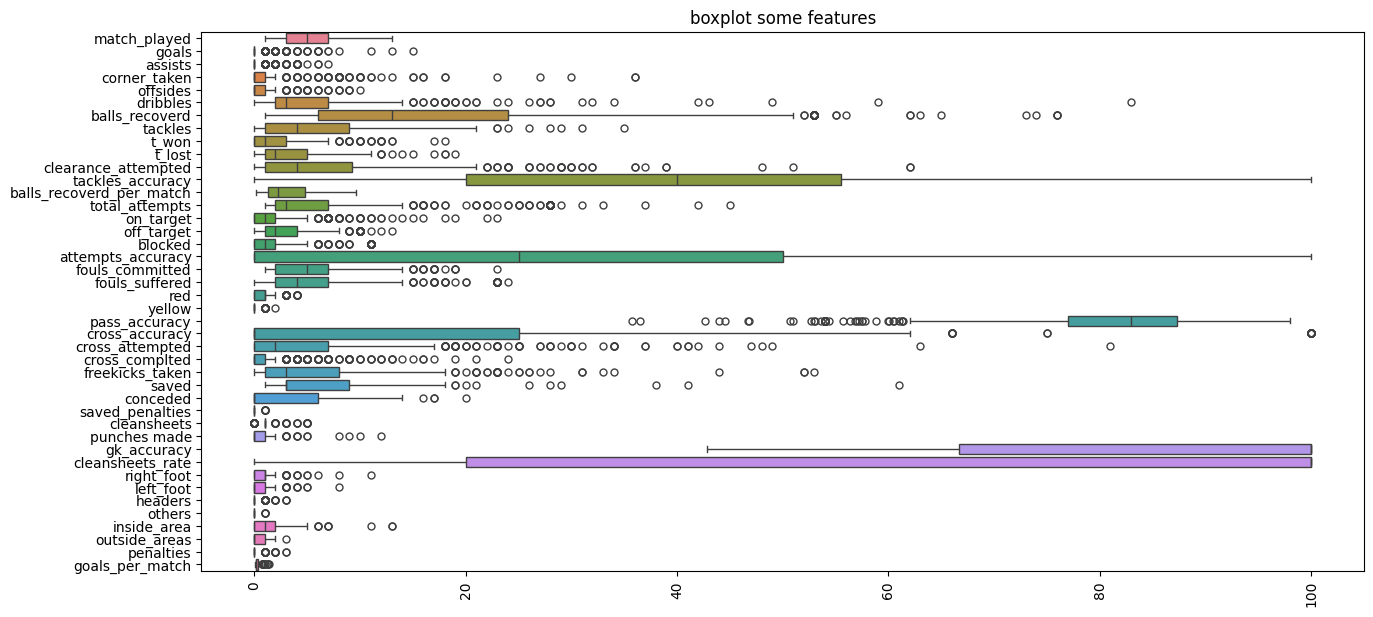

In [9]:
plt.figure(figsize=((15,7)))
plt.title('boxplot some features')
data = df.drop(columns=['minutes_played', 'pass_attempted', 'pass_completed'])
food_box=sns.boxplot(data=data,fliersize=5, orient='h')
plt.xticks(rotation=90)
plt.show()

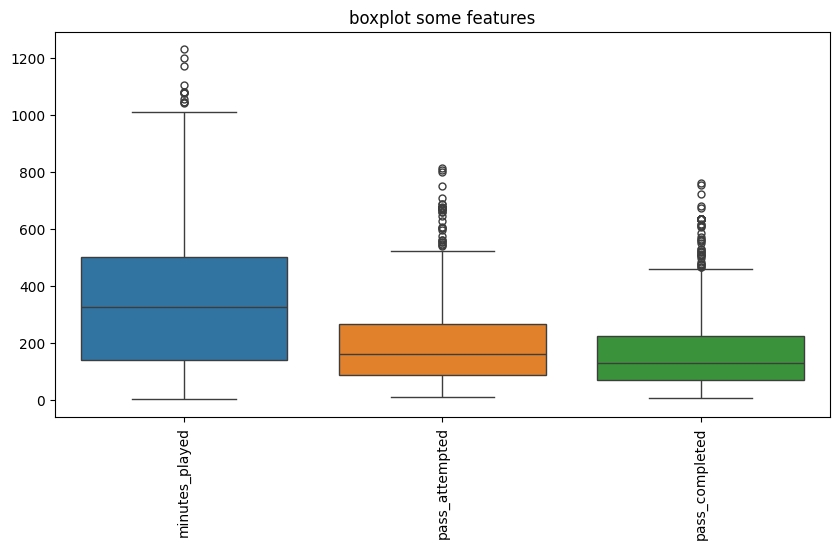

In [10]:
plt.figure(figsize=((10,5)))
plt.title('boxplot some features')
data = df[['minutes_played', 'pass_attempted', 'pass_completed']]
food_box=sns.boxplot(data=data,fliersize=5)
plt.xticks(rotation=90)
plt.show()

# Factorial analysis

In [11]:
def plot_corr(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap)

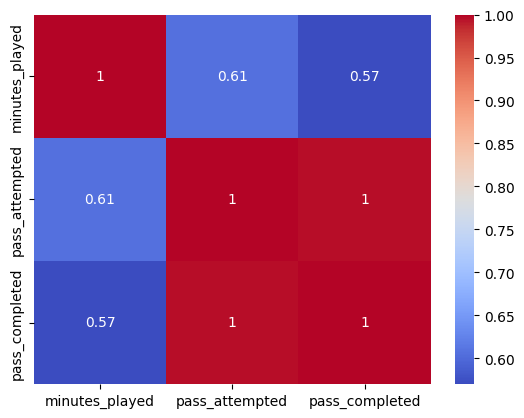

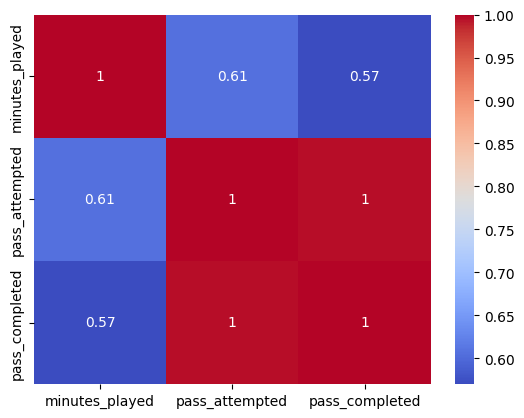

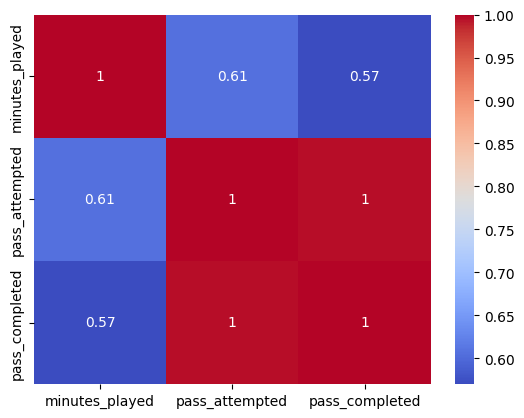

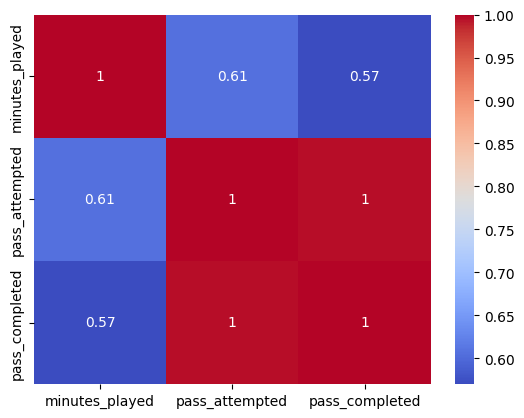

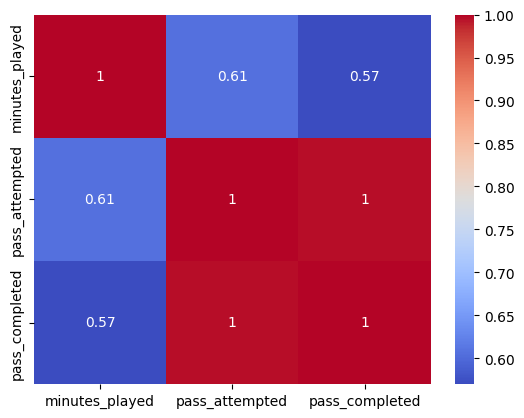

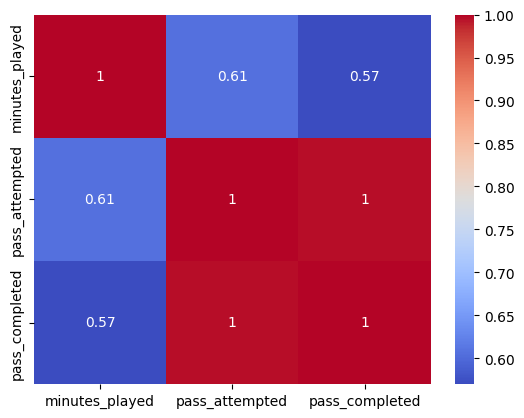

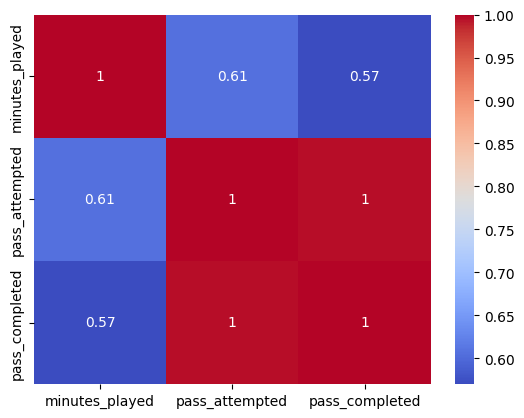

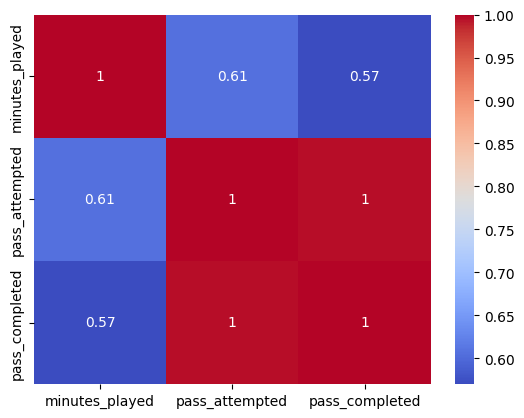

In [12]:
for dataframe in dataframes:
    corr = data.select_dtypes(exclude='object').corr()
    if corr.shape[0] > 1 and not corr.isnull().all().all():
        plt.figure()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.show()
    else:
        print("La matrice de corrélation est vide ou n'a qu'une seule colonne.")

<Axes: >

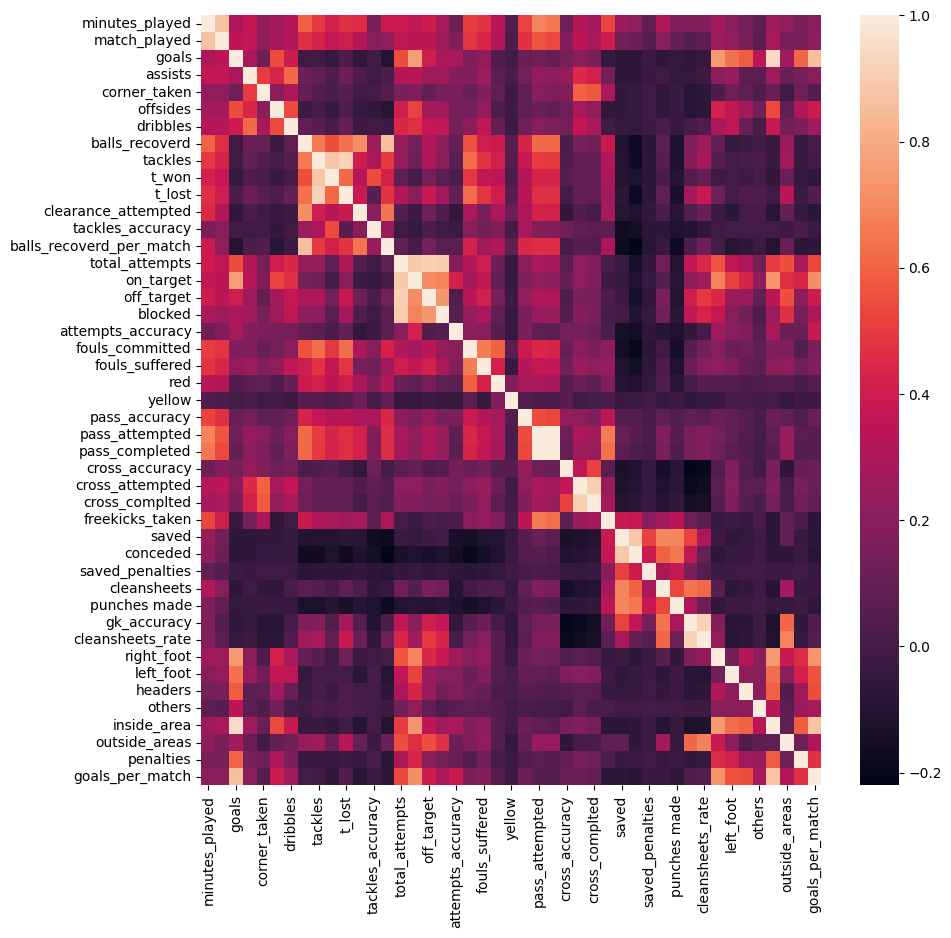

In [13]:
corr = df.select_dtypes(exclude='object').fillna(value=0).corr()
plt.figure(figsize=((10,10)))
sns.heatmap(corr)

# PCA

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [15]:
X = df.select_dtypes(exclude='object').fillna(value=0).values
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [16]:
pca = PCA().fit(X_scaled)

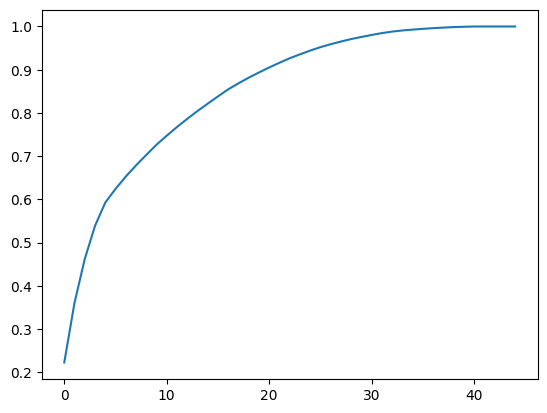

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [18]:
X_proj = pca.transform(X_scaled)

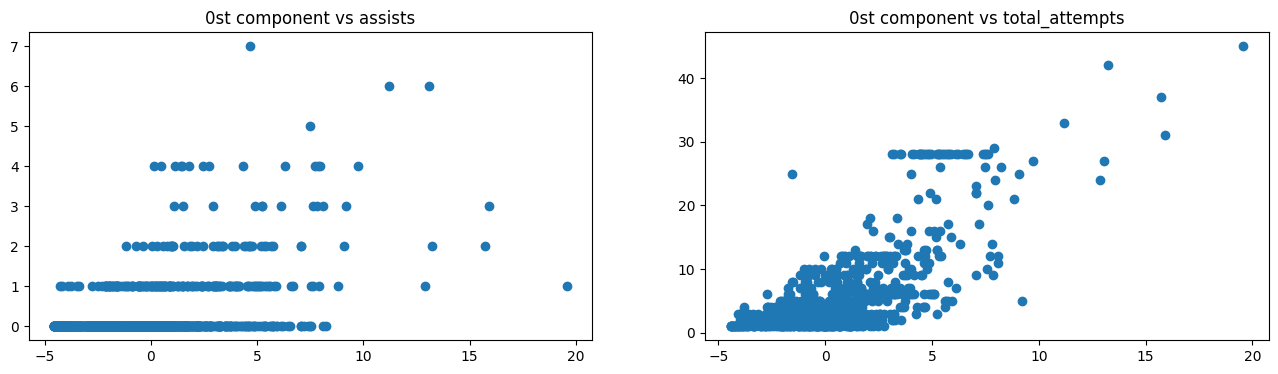

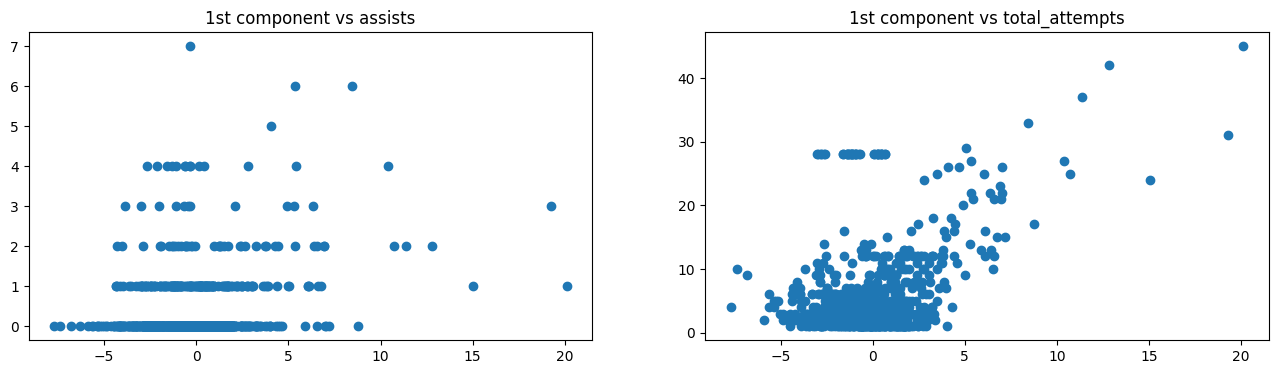

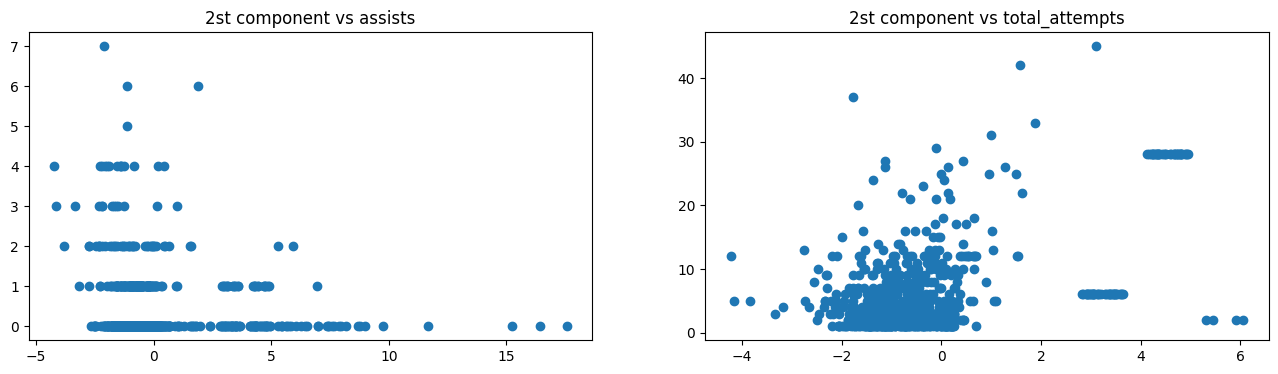

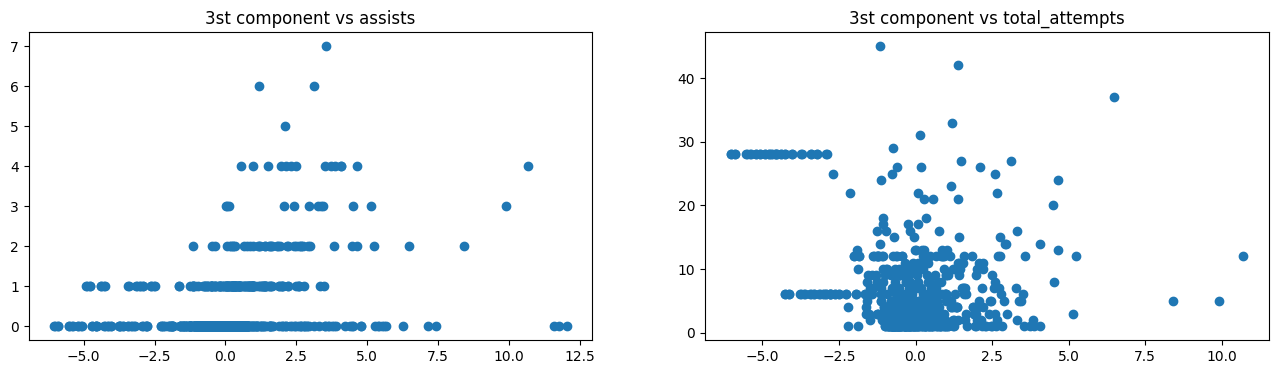

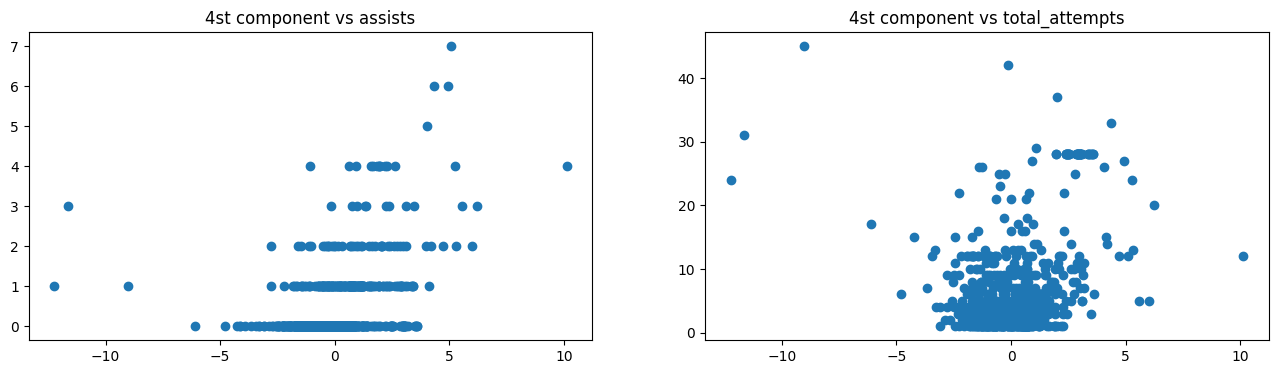

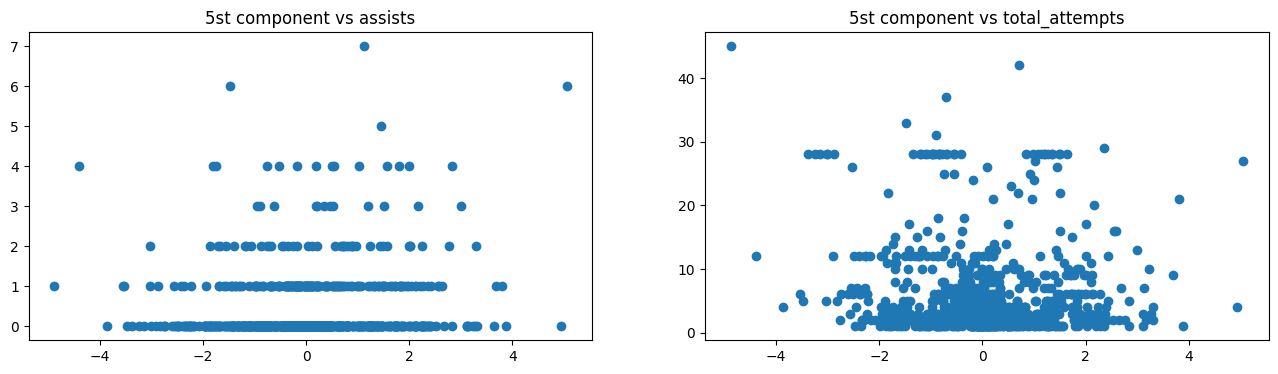

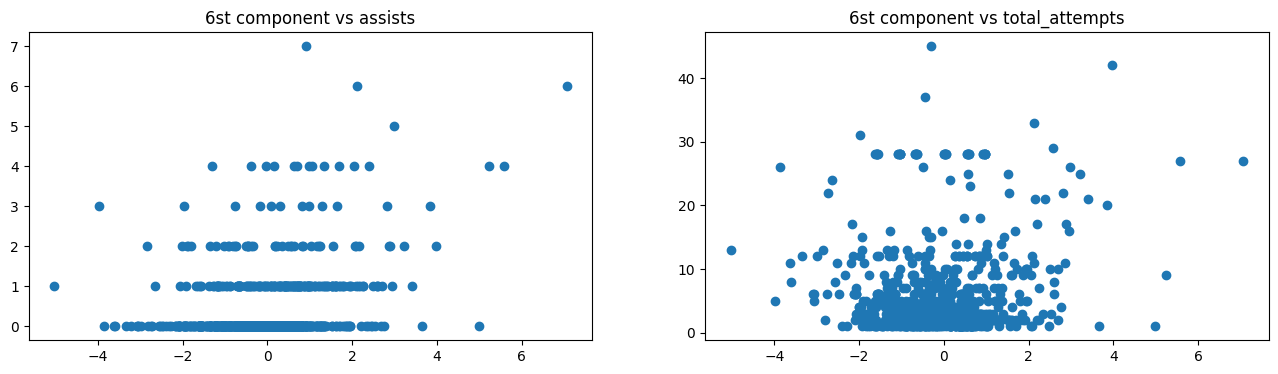

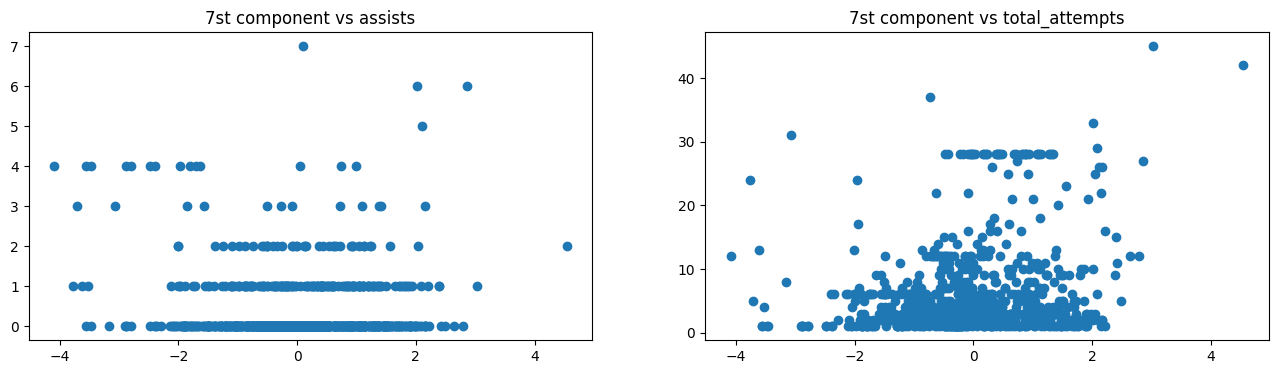

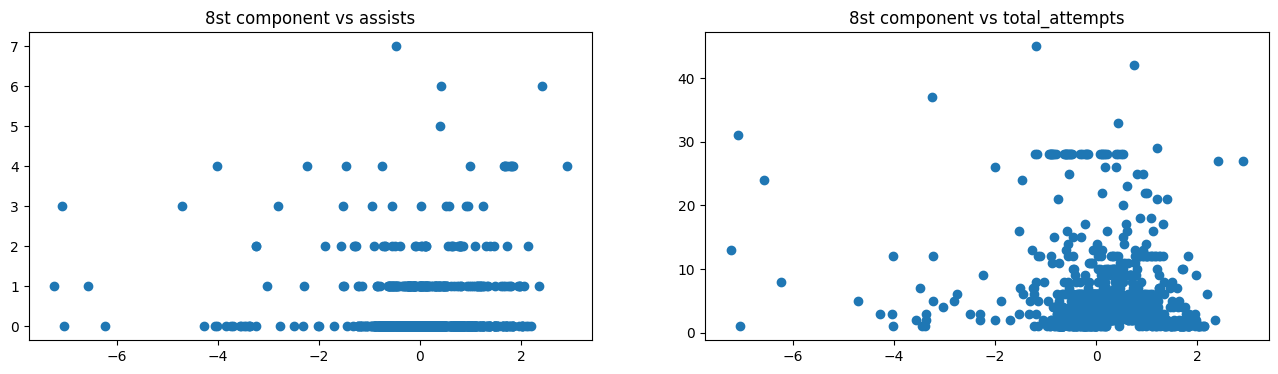

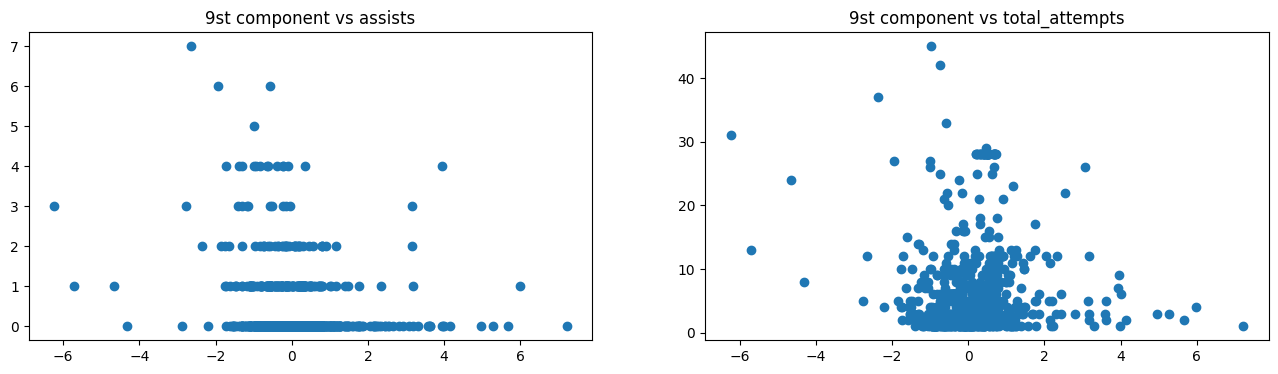

In [19]:
for num in range(0,10):
    _, axes = plt.subplots(ncols=2, figsize=(16,4))
    for i, (ax, col) in enumerate(zip(axes, ['assists', 'total_attempts'])):
        ax.scatter(X_proj[:,num], df[col])
        ax.set_title(f'{num}st component vs {col}')

# FA

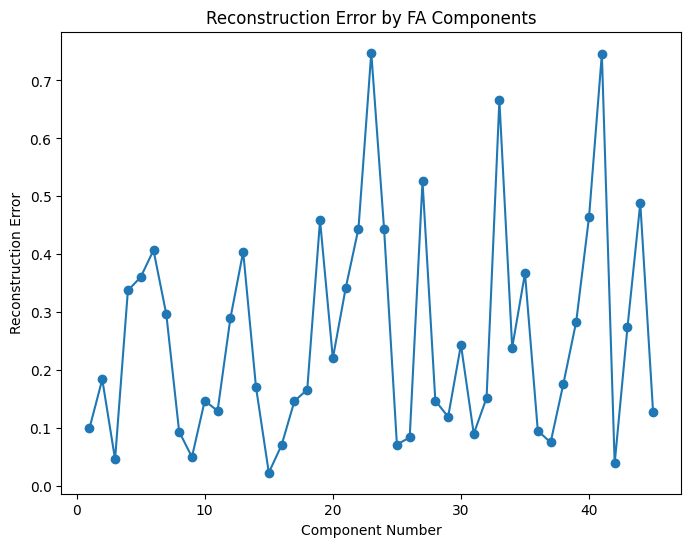

In [20]:
X = df.select_dtypes(exclude='object').fillna(value=0).values

# Step 2: Standardize the data
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Step 3: Apply Factor Analysis (FA)
fa = FactorAnalysis(n_components=X_scaled.shape[1], random_state=42)
X_fa = fa.fit_transform(X_scaled)

# Step 4: Compute the reconstruction of the original data using the factor loadings
# Reconstruct the original data using the learned latent factors
reconstructed = np.dot(X_fa, fa.components_) + fa.mean_

# Step 5: Compute the reconstruction error
reconstruction_error = np.mean((X_scaled - reconstructed) ** 2, axis=0)

# Step 6: Plot the reconstruction error for each factor
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(reconstruction_error) + 1), reconstruction_error, marker='o')
plt.title('Reconstruction Error by FA Components')
plt.xlabel('Component Number')
plt.ylabel('Reconstruction Error')
plt.show()

# Clustering

# K-Means

In [21]:
# K-means function
from sklearn.cluster import KMeans

# Functions for silhouette
from sklearn.metrics import silhouette_samples, silhouette_score


In [22]:
# Compute the silhouette index for each cluster number
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n, n_init=10).fit(X_scaled) 
    cluster_labels = clusterer.labels_ 
    silhouette_avg = silhouette_score(X_scaled, cluster_labels) 
   
    # Display the results
    print("For n =", n, "Silhouette_score:", silhouette_avg)

For n = 2 Silhouette_score: 0.19547551448473355
For n = 3 Silhouette_score: 0.18616936832058364
For n = 4 Silhouette_score: 0.18817202628372032
For n = 5 Silhouette_score: 0.2029556404090624
For n = 6 Silhouette_score: 0.1297924757346594
For n = 7 Silhouette_score: 0.14429508192001653
For n = 8 Silhouette_score: 0.14593185568461883
For n = 9 Silhouette_score: 0.14518235828050002
For n = 10 Silhouette_score: 0.15583369155488005


# Hierarchical

In [23]:
# Functions for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [24]:
# We now perform hierarchical clustering. 

# We standardize the columns of interest
# scale(food) returns a numpy array, so use pd.Dataframe to reconstruct your dataframe


# We apply hierarchical clustering with dissimilarity measure "ward"
Z = linkage(X_scaled, 'ward') # 'average' is the method used to compute the distance. Metric is "euclidian" by default
print(Z)

[[6.92000000e+02 9.91000000e+02 0.00000000e+00 2.00000000e+00]
 [2.64000000e+02 9.87000000e+02 0.00000000e+00 2.00000000e+00]
 [8.50000000e+01 7.96000000e+02 0.00000000e+00 2.00000000e+00]
 ...
 [1.99500000e+03 1.99800000e+03 7.99650420e+01 5.11000000e+02]
 [2.00000000e+03 2.00100000e+03 8.15447944e+01 4.92000000e+02]
 [2.00200000e+03 2.00300000e+03 1.04782324e+02 1.00300000e+03]]


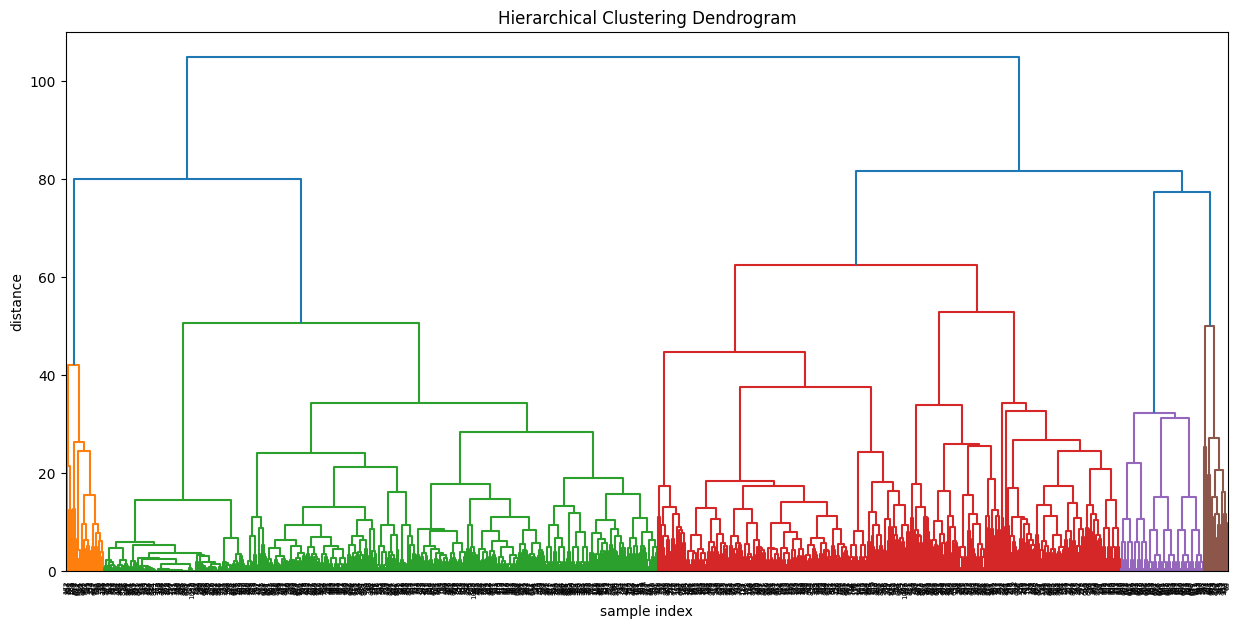

In [25]:
# We represent the corresponding Dendrogram
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z = linkage(X_scaled, 'ward')
)
plt.show()

In [26]:
metrics=['euclidean','hamming', 'cityblock' , 'cosine'] # metrics used for linkage 
methods=['single','complete','average'] # methods used for linkage
pdists=['euclidean','minkowski','cityblock','cosine']  # metrics used for pdist()
max_val=0
best_metric=None
best_method=None
best_p_dist=None

for metric1 in metrics:
    for method1 in methods:
        for pdist1 in pdists:
            Z=linkage(X_scaled,method1,metric=metric1)
            c, coph_dists = cophenet(Z, pdist(X_scaled,pdist1))
            if (c>max_val):
                max_val=c
                best_metric=metric1
                best_method=method1
                best_p_dist=pdist1
            else:
                max_val=max_val
            print('(',method1,',',metric1,',',pdist1,') :',c)
print('the best cophenet index is about :',max_val,'which corresponds to the triple: (metric=',best_metric,',method=',best_method,'and pdist=',best_p_dist,')')

( single , euclidean , euclidean ) : 0.8873672622554981
( single , euclidean , minkowski ) : 0.8873672622554981
( single , euclidean , cityblock ) : 0.8367911523900383
( single , euclidean , cosine ) : 0.2990052959216321
( complete , euclidean , euclidean ) : 0.7477660505018578
( complete , euclidean , minkowski ) : 0.7477660505018578
( complete , euclidean , cityblock ) : 0.7087831847041919
( complete , euclidean , cosine ) : 0.5163311071043087
( average , euclidean , euclidean ) : 0.9204545216277855
( average , euclidean , minkowski ) : 0.9204545216277855
( average , euclidean , cityblock ) : 0.8612996270290034
( average , euclidean , cosine ) : 0.3500568445040405
( single , hamming , euclidean ) : 0.5853401297235292
( single , hamming , minkowski ) : 0.5853401297235292
( single , hamming , cityblock ) : 0.7047059811178263
( single , hamming , cosine ) : 0.47364838264524683
( complete , hamming , euclidean ) : 0.3189432657443102
( complete , hamming , minkowski ) : 0.3189432657443102

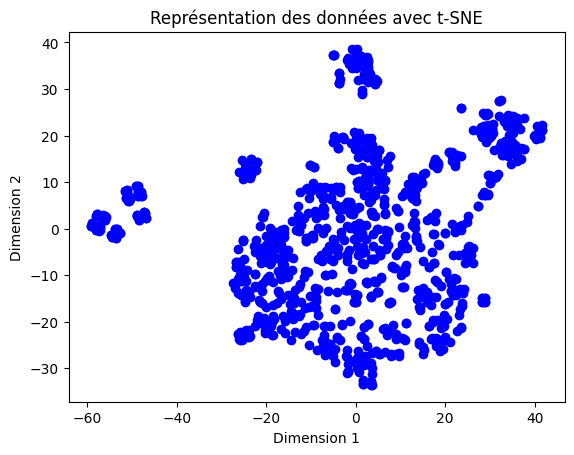

In [47]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne= TSNE(n_components=2, learning_rate='auto',
                  init='random')
X_tsne=tsne.fit_transform(X_scaled)

#print(X_scaled.shape,X_tsne.shape)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', marker='o')

# Ajout des titres et des labels
plt.title('Représentation des données avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Affichage du graphique
plt.show()



In [46]:
from sklearn.manifold import trustworthiness

# Boucle sur différentes valeurs pour le nombre de dimensions (de 1 à 9)
for i in range(1, 4):
    # Application de t-SNE avec 'i' dimensions
    tsnex = TSNE(n_components=i, learning_rate='auto', init='random')
    X_tsnex = tsnex.fit_transform(X_scaled)
    
    # Calcul du score de trustworthiness avec 5 voisins
    trust = trustworthiness(X_scaled, X_tsnex, n_neighbors=5)
    
    # Affichage du score pour chaque nombre de dimensions
    print(f"Trustworthiness score for {i} dimensions: {trust:.2f}")


Trustworthiness score for 1 dimensions: 0.95
Trustworthiness score for 2 dimensions: 0.98
Trustworthiness score for 3 dimensions: 0.99


In [48]:
# Compute the silhouette index for each cluster number
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n, n_init=10).fit(X_tsne) # Clustering with the given number of clusters
    cluster_labels = clusterer.labels_ # Extract the labels
    silhouette_avg = silhouette_score(X_tsne, cluster_labels) # Corresponding silhouette score
   
    # Display the results
    print("For n =", n, "Silhouette_score:", silhouette_avg)

For n = 2 Silhouette_score: 0.37378716
For n = 3 Silhouette_score: 0.37948263
For n = 4 Silhouette_score: 0.4151319
For n = 5 Silhouette_score: 0.46066275
For n = 6 Silhouette_score: 0.45754746
For n = 7 Silhouette_score: 0.46352154
For n = 8 Silhouette_score: 0.4595653
For n = 9 Silhouette_score: 0.47561163
For n = 10 Silhouette_score: 0.46975973


[[  3.3109145   10.777889  ]
 [  1.6936111  -25.740118  ]
 [-19.103409   -14.330476  ]
 [-15.665138     3.927735  ]
 [ 30.882936    18.2732    ]
 [-52.718964     3.2645004 ]
 [ 20.096287   -11.62555   ]
 [  2.408407    -7.2092986 ]
 [  0.35876554  34.266987  ]]


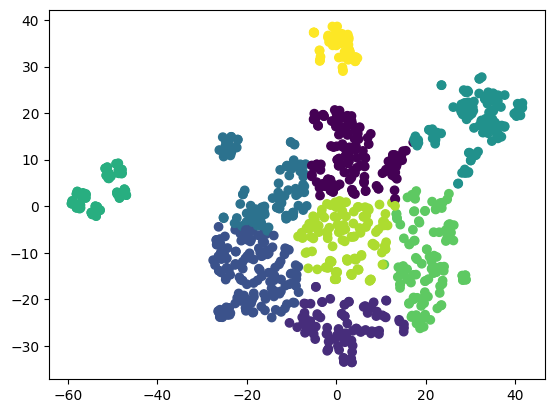

In [49]:
# We run a K-means algorithm onto the ruspini dataset, and display the centers
kmeans = KMeans(n_clusters=9,n_init=40,init='random').fit(X_tsne)
centers=kmeans.cluster_centers_
print(centers)

# We also represent the data in 2D-space with colors corresponding to cluster
kmeans.labels_
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=kmeans.labels_)